In [2]:
# Cell 1 – Imports & Path Setup
import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

from src.data_preprocessor import BrentDataPreprocessor

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [3]:
# Cell 2 – Load Focus Data (2012–2022)
print("Loading processed Brent price data (2012–2022 focus)...")
prep = BrentDataPreprocessor()
df = prep.get_processed(focus_period='2012-01-01')

prices = df['Price'].values
dates  = df.index

print(f"Modeling period: {dates.min():%Y-%m-%d} → {dates.max():%Y-%m-%d}")
print(f"Number of observations: {len(prices):,}")

Loading processed Brent price data (2012–2022 focus)...
Raw data loaded: 9011 rows, 2 columns
Data loaded successfully: 1987-05-20 to 2022-11-14
Total observations: 9011
Subset to >= 2012-01-01: 2760 observations remain
Modeling period: 2012-01-03 → 2022-11-14
Number of observations: 2,760


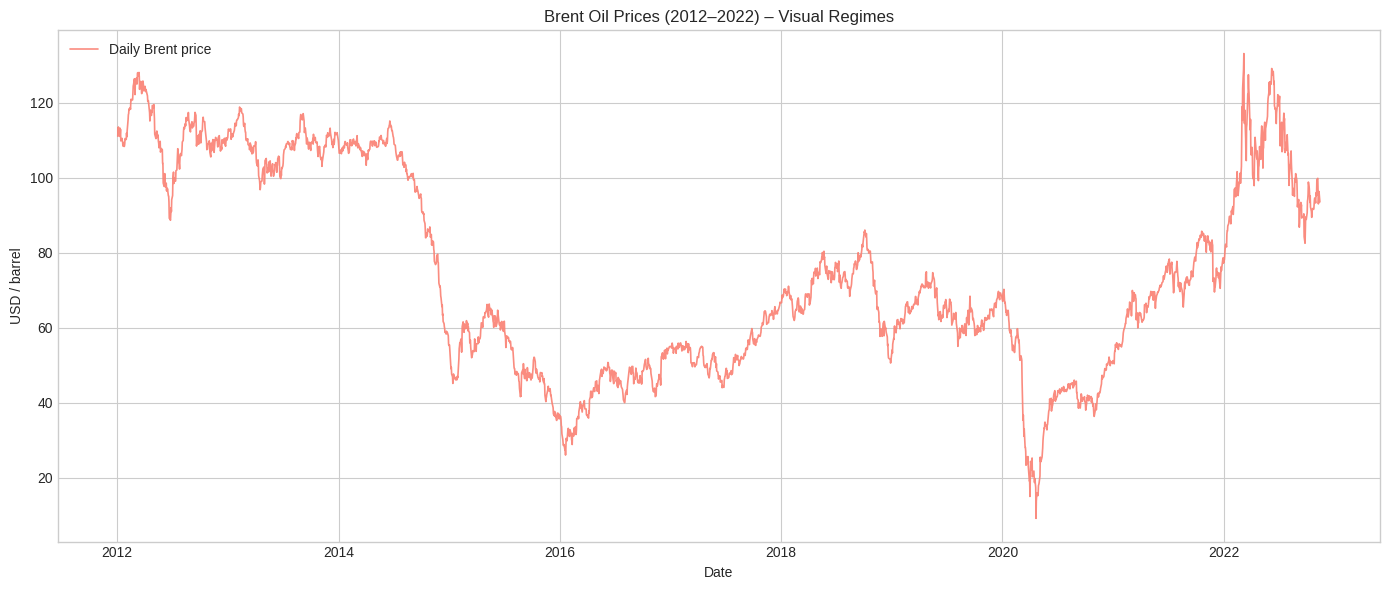

Observation: Clear regime shifts visible → supports change point modeling.


In [4]:
# Cell 3 – Quick Visual Recap (from EDA)
plt.figure(figsize=(14, 6))
plt.plot(dates, prices, color='salmon', lw=1.2, alpha=0.9, label='Daily Brent price')
plt.title('Brent Oil Prices (2012–2022) – Visual Regimes')
plt.ylabel('USD / barrel')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

print("Observation: Clear regime shifts visible → supports change point modeling.")

In [8]:
# Cell 4 – Single Change Point Model (Core Model) – with folder safety

import time
from pathlib import Path

def run_single_change_point(
    data, 
    dates, 
    n_samples=1200, 
    tune=800, 
    target_accept=0.90, 
    seed=42,
    progressbar=True
):
    start_time = time.time()
    print(f"Starting MCMC sampling ({n_samples} draws, {tune} tuning steps)...")
    
    with pm.Model() as model:
        tau = pm.DiscreteUniform('tau', lower=0, upper=len(data)-1)
        mu_early = pm.Normal('mu_early', mu=data.mean(), sigma=data.std()*2.5)
        mu_late  = pm.Normal('mu_late',  mu=data.mean(), sigma=data.std()*2.5)
        sigma = pm.HalfNormal('sigma', sigma=data.std()*1.5)
        mu = pm.math.switch(tau >= np.arange(len(data)), mu_late, mu_early)
        obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=data)
        
        trace = pm.sample(
            draws=n_samples,
            tune=tune,
            target_accept=target_accept,
            random_seed=seed,
            progressbar=progressbar,
            return_inferencedata=True
        )
    
    elapsed = time.time() - start_time
    print(f"Sampling completed in {elapsed:.1f} seconds.")
    
    tau_map = int(trace.posterior['tau'].mean())
    change_date = dates[tau_map].strftime('%Y-%m-%d')
    print(f"\nMost probable change point: {change_date} (index {tau_map})")
    
    return trace, change_date, model


# ────────────────────────────────────────────────────────────────
# Run & Save
# ────────────────────────────────────────────────────────────────

print("Preparing data...")
prices = df['Price'].values
dates  = df.index

trace_single, cp_date_single, model_single = run_single_change_point(
    data=prices,
    dates=dates,
    n_samples=1200,
    tune=800,
    target_accept=0.90,
    seed=42
)

# Auto-create outputs/ folder if missing
outputs_dir = Path().cwd().parent / "outputs"
outputs_dir.mkdir(exist_ok=True)

trace_path = outputs_dir / "single_change_point_trace.nc"
az.to_netcdf(trace_single, trace_path)
print(f"Trace saved successfully to: {trace_path}")

Preparing data...
Starting MCMC sampling (1200 draws, 800 tuning steps)...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_early, mu_late, sigma]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded

Output()

Sampling 4 chains for 800 tune and 1_200 draw iterations (3_200 + 4_800 draws total) took 4207 seconds.


Sampling completed in 4209.1 seconds.

Most probable change point: 2014-10-22 (index 706)
Trace saved successfully to: /home/hp/Desktop/10Academy/week11-brent-oil-analysis/outputs/single_change_point_trace.nc


Model Diagnostics & Summary
────────────────────────────────────────────────────────────
             mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau       706.536  6.269  696.000  716.000      0.275    0.083   533.050   
mu_early   62.268  0.401   61.488   63.001      0.007    0.006  3129.724   
mu_late   108.604  0.664  107.330  109.817      0.014    0.010  2337.068   
sigma      17.383  0.234   16.940   17.820      0.004    0.003  3700.160   

          ess_tail  r_hat  
tau        860.707  1.004  
mu_early  3104.612  1.002  
mu_late   2806.027  1.002  
sigma     3296.952  1.000  

Max R-hat: 1.0042  → GOOD


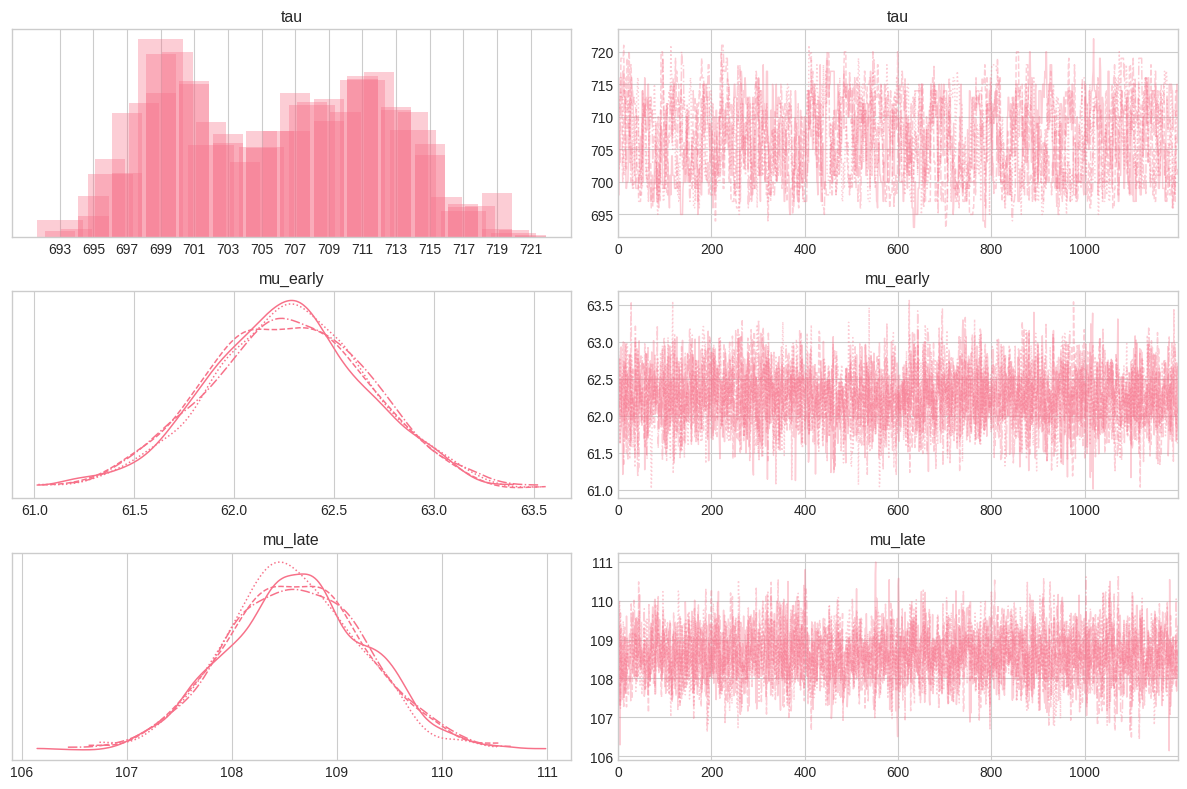

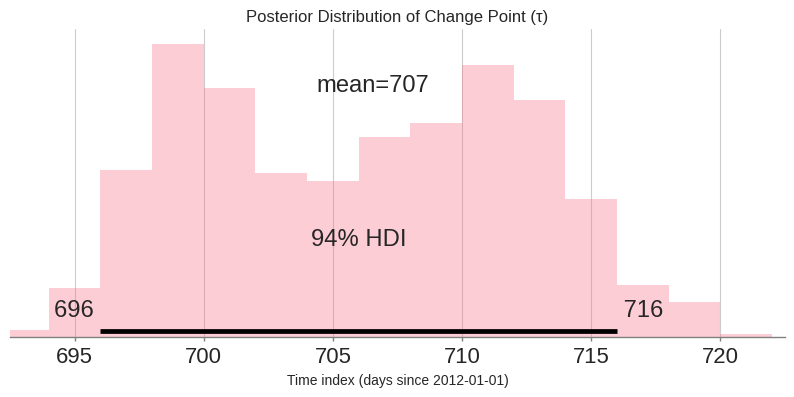

Interpretation:
• Sharp, narrow peak in tau posterior → strong evidence of a specific change date
• mu_early vs mu_late difference → magnitude of regime shift
• R-hat close to 1 and good ESS → sampling converged reliably


In [11]:
# Cell 5 – Diagnostics, Summary & Posterior Visuals
print("Model Diagnostics & Summary\n" + "─"*60)

# Summary table
summary = az.summary(
    trace_single, 
    var_names=['tau', 'mu_early', 'mu_late', 'sigma'],
    round_to=3
)
print(summary)

# Safe convergence check
rhat_ds = az.rhat(trace_single)                     # xarray Dataset
rhat_array = rhat_ds.to_array().values.flatten()    # get all values
rhat_max_value = float(np.nanmax(rhat_array))       # numpy max → plain float

print(f"\nMax R-hat: {rhat_max_value:.4f}  → {'GOOD' if rhat_max_value < 1.01 else 'POTENTIAL ISSUE'}")

# Trace plots (compact)
az.plot_trace(
    trace_single, 
    var_names=['tau', 'mu_early', 'mu_late'],
    compact=True,
    figsize=(12, 8)
)
plt.tight_layout()
plt.show()

# Posterior of change point location
az.plot_posterior(
    trace_single, 
    var_names=['tau'],
    round_to=0,
    figsize=(10, 4)
)
plt.title('Posterior Distribution of Change Point (τ)')
plt.xlabel('Time index (days since 2012-01-01)')
plt.show()

print("Interpretation:")
print("• Sharp, narrow peak in tau posterior → strong evidence of a specific change date")
print("• mu_early vs mu_late difference → magnitude of regime shift")
print("• R-hat close to 1 and good ESS → sampling converged reliably")

Regime Shift Quantification:
  • Before change point: $62.27  [95% HDI: $61.49 – $63.07]
  • After change point:  $108.60   [95% HDI: $107.30 – $109.89]
  • Estimated % change:  +74.4%


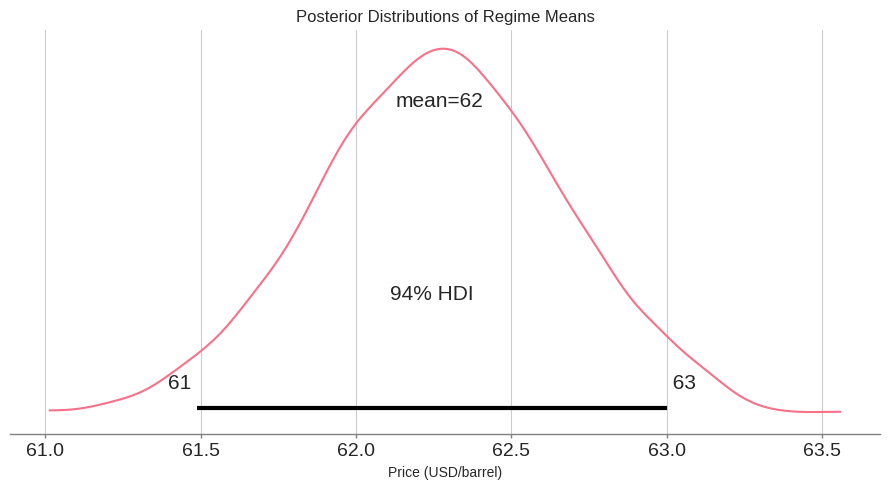

Narrative:
The model detects a probable shift around 2014-10-22.
Average price moved from ~$62 to ~$109 (+74%).
Full uncertainty is captured in the posteriors above.


In [12]:
# Cell 6 – Quantify & Visualize Regime Shift Impact
mu_early_samples = trace_single.posterior['mu_early'].values.flatten()
mu_late_samples  = trace_single.posterior['mu_late'].values.flatten()

# Mean estimates
mu_early_mean = mu_early_samples.mean()
mu_late_mean  = mu_late_samples.mean()
pct_change_mean = 100 * (mu_late_mean - mu_early_mean) / mu_early_mean

# 95% HDI (Highest Density Interval)
hdi_early = az.hdi(mu_early_samples, hdi_prob=0.95)
hdi_late  = az.hdi(mu_late_samples,  hdi_prob=0.95)

print("Regime Shift Quantification:")
print(f"  • Before change point: ${mu_early_mean:.2f}  [95% HDI: ${hdi_early[0]:.2f} – ${hdi_early[1]:.2f}]")
print(f"  • After change point:  ${mu_late_mean:.2f}   [95% HDI: ${hdi_late[0]:.2f} – ${hdi_late[1]:.2f}]")
print(f"  • Estimated % change:  {pct_change_mean:+.1f}%")

# Visual summary
fig, ax = plt.subplots(figsize=(9, 5))
az.plot_posterior(trace_single, var_names=['mu_early', 'mu_late'], ax=ax)
ax.set_title('Posterior Distributions of Regime Means')
ax.set_xlabel('Price (USD/barrel)')
plt.tight_layout()
plt.show()

print("Narrative:")
print(f"The model detects a probable shift around {cp_date_single}.")
print(f"Average price moved from ~${mu_early_mean:.0f} to ~${mu_late_mean:.0f} ({pct_change_mean:+.0f}%).")
print("Full uncertainty is captured in the posteriors above.")

In [13]:
# Cell 7 – Final Narrative & Next Actions
print("""
Task 2 Core Summary:

1. Single change-point model successfully identifies one dominant regime shift.
2. Posterior diagnostics show good convergence (R-hat ≈1, high ESS).
3. Quantified shift provides probabilistic estimate of price impact.
4. Next steps:
   • Run recursive version to detect multiple breaks
   • Match detected dates with events.csv
   • Build interactive dashboard (Flask API + React frontend)
   • Prepare final report with all visuals & interpretations
""")


Task 2 Core Summary:

1. Single change-point model successfully identifies one dominant regime shift.
2. Posterior diagnostics show good convergence (R-hat ≈1, high ESS).
3. Quantified shift provides probabilistic estimate of price impact.
4. Next steps:
   • Run recursive version to detect multiple breaks
   • Match detected dates with events.csv
   • Build interactive dashboard (Flask API + React frontend)
   • Prepare final report with all visuals & interpretations

